In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout

In [14]:
# 1. Load the dataset
data = pd.read_csv('/kaggle/input/globalweatherrepository/GlobalWeatherRepository.csv')
data

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.5200,69.1800,Asia/Kabul,1715849100,16-05-2024 13:15,26.6,79.8,Partly Cloudy,...,8.400,26.600,1,1,4:50 AM,6:50 PM,12:12 PM,1:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.3300,19.8200,Europe/Tirane,1715849100,16-05-2024 10:45,19.0,66.2,Partly cloudy,...,1.100,2.000,1,1,5:21 AM,7:54 PM,12:58 PM,2:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.7600,3.0500,Africa/Algiers,1715849100,16-05-2024 09:45,23.0,73.4,Sunny,...,10.400,18.400,1,1,5:40 AM,7:50 PM,1:15 PM,2:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.5000,1.5200,Europe/Andorra,1715849100,16-05-2024 10:45,6.3,43.3,Light drizzle,...,0.700,0.900,1,1,6:31 AM,9:11 PM,2:12 PM,3:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.8400,13.2300,Africa/Luanda,1715849100,16-05-2024 09:45,26.0,78.8,Partly cloudy,...,183.400,262.300,5,10,6:12 AM,5:55 PM,1:17 PM,12:38 AM,Waxing Gibbous,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47547,Venezuela,Caracas,10.5000,-66.9167,America/Caracas,1737022500,16-01-2025 06:15,22.1,71.8,Clear,...,6.290,8.140,1,1,6:50 AM,6:25 PM,9:00 PM,8:58 AM,Waning Gibbous,94
47548,Vietnam,Hanoi,21.0333,105.8500,Asia/Bangkok,1737018900,16-01-2025 16:15,22.3,72.1,Sunny,...,103.785,104.895,4,10,6:36 AM,5:37 PM,7:54 PM,8:21 AM,Waning Gibbous,96
47549,Yemen,Sanaa,15.3547,44.2067,Asia/Aden,1737022500,16-01-2025 13:15,20.9,69.7,Sunny,...,5.550,10.545,1,1,6:33 AM,5:53 PM,8:16 PM,8:27 AM,Waning Gibbous,96
47550,Zambia,Lusaka,-15.4167,28.2833,Africa/Lusaka,1737022500,16-01-2025 12:15,27.0,80.5,Patchy rain nearby,...,22.570,22.755,2,2,5:49 AM,6:44 PM,8:53 PM,7:55 AM,Waning Gibbous,96


In [15]:
# Display basic info about the dataset
print("Dataset shape:", data.shape)
print("Columns:", data.columns.tolist())

Dataset shape: (47552, 41)
Columns: ['country', 'location_name', 'latitude', 'longitude', 'timezone', 'last_updated_epoch', 'last_updated', 'temperature_celsius', 'temperature_fahrenheit', 'condition_text', 'wind_mph', 'wind_kph', 'wind_degree', 'wind_direction', 'pressure_mb', 'pressure_in', 'precip_mm', 'precip_in', 'humidity', 'cloud', 'feels_like_celsius', 'feels_like_fahrenheit', 'visibility_km', 'visibility_miles', 'uv_index', 'gust_mph', 'gust_kph', 'air_quality_Carbon_Monoxide', 'air_quality_Ozone', 'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10', 'air_quality_us-epa-index', 'air_quality_gb-defra-index', 'sunrise', 'sunset', 'moonrise', 'moonset', 'moon_phase', 'moon_illumination']


In [16]:
# 2. Prepare data for regression
# Set target variable as 'air_quality_PM2.5'
target_column = 'air_quality_PM2.5'
if target_column not in data.columns:
    raise ValueError(f"Column {target_column} not found in dataset.")

# For simplicity, we will drop rows with missing target values and any rows with missing feature values.
data = data.dropna(subset=[target_column])
data = data.dropna()

# Define features: exclude target column (and possibly non-numeric columns, e.g., date or text)
# We take only the numeric columns as features.
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
if target_column in numeric_cols:
    numeric_cols.remove(target_column)
    
X = data[numeric_cols].values
y = data[target_column].values

In [17]:
# 3. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# 4. Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
# For a 1D CNN, we reshape our data to have a "time step" dimension.
# Each sample will be reshaped from (n_features,) to (n_features, 1)
n_features = X_train_scaled.shape[1]
X_train_scaled = X_train_scaled.reshape(-1, n_features, 1)
X_test_scaled = X_test_scaled.reshape(-1, n_features, 1)

In [20]:
# Build CNN-LSTM model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_features, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 27, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 13, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 13, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,393 (138.25 KB)

 Trainable params: 35,393 (138.25 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [22]:
# Train
history = model.fit(X_train_scaled, y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_split=0.1,
                    callbacks=[early_stop])

Epoch 1/50
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 1896.1842 - val_loss: 502.5611
Epoch 2/50
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 453.9977 - val_loss: 266.3233
Epoch 3/50
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 238.0765 - val_loss: 170.6211
Epoch 4/50
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 181.4993 - val_loss: 102.5813
Epoch 5/50
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 148.0508 - val_loss: 93.0738
Epoch 6/50
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 120.9660 - val_loss: 63.9345
Epoch 7/50
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 108.7916 - val_loss: 59.2534
Epoch 8/50
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 85.1145 - val_loss: 46.7018
Epoch 9/50
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 90.0819 - val_loss: 39.9740
Epoch 10/50
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 119.5406 - val_loss: 43.7406
Epoch 11/50
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 82.9001 - v

In [23]:
# 7. Evaluate the model on the test set
y_pred = model.predict(X_test_scaled).flatten()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest Metrics:")
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R^2 Score:", r2)

298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Test Metrics:
Mean Squared Error (MSE): 32.82854087578563
Mean Absolute Error (MAE): 2.6025955642142287
R^2 Score: 0.9837935023432669


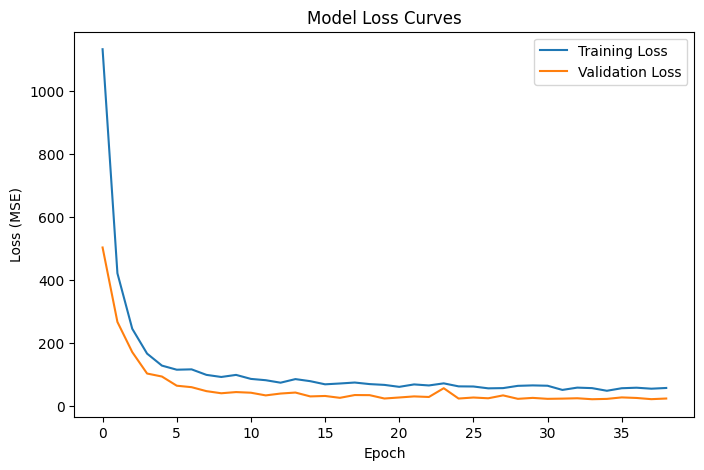

In [24]:
# 9. Plot loss curves for training and validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

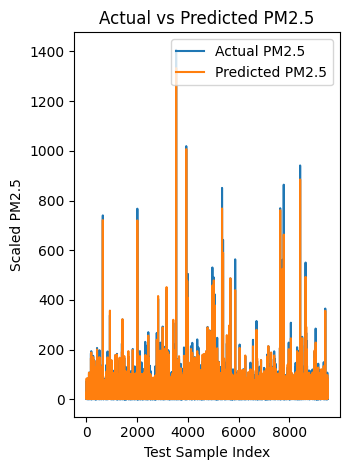

In [25]:
# Plot actual vs predicted on the test set
plt.subplot(1, 2, 2)
plt.plot(y_test, label='Actual PM2.5')
plt.plot(y_pred, label='Predicted PM2.5')
plt.title('Actual vs Predicted PM2.5')
plt.xlabel('Test Sample Index')
plt.ylabel('Scaled PM2.5')
plt.legend()

plt.tight_layout()
plt.show()